In [22]:
from pathlib import Path
import pandas as pd
import pandas.plotting
import tarfile
import urllib.request
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.impute import SimpleImputer

In [2]:
def load_housing_data():
    #this line looks for datasets/housing.tgz file
    tarball_path = Path("datasets/housing.tgz")

    #if it does not find it:
    if not tarball_path.is_file():  #is_file() checks if the path points to a file
        #this creates a "datasets" directory, and if it already exists, it does not raise an error
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"

        #downloads the data at url and saves it to the path specified in tarball_path
        urllib.request.urlretrieve(url, tarball_path)

        #opens the file at tarball_path
        with tarfile.open(tarball_path) as housing_tarball:
            #extracts all files in the datasets folder
            housing_tarball.extractall(path="datasets")

        #returns the .csv file
    return pd.read_csv(Path("datasets/housing/housing.csv"))

#loading the csv file by calling the above defined function  
housing = load_housing_data()

# Taking a look at the Data

In [3]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


It can be seen that ocean_proximity has data type of object, it means it could be a string. If you look at the head() output, it looks like a categorical column

The below cell checks the categories and the number of entries in each

In [5]:
housing["ocean_proximity"].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

In [6]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


Plotting histogram of all numerical columns:

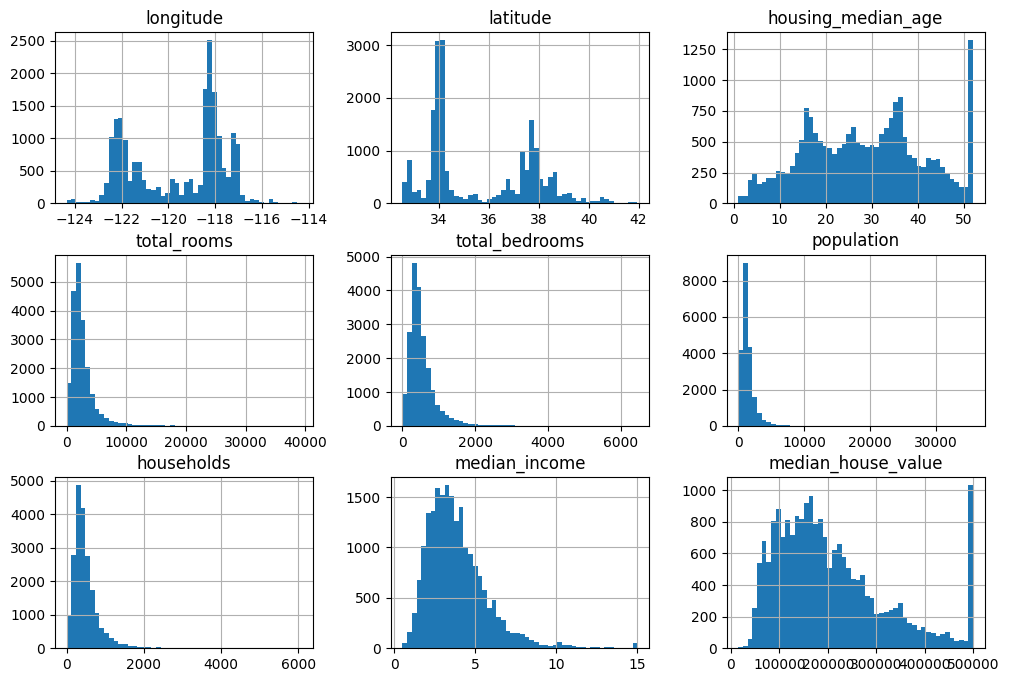

In [7]:
housing.hist(bins=50, figsize=(12,8))
plt.show()

Interpretting the histograms:
1. HOUSING MEDIAN Age - There are a lot of people (1250) aged 50, this indicates the data has been capped.
2. MEDIAN INCOME - It is not look like it is expressed in US Dollars, the data is scaled and capped at 15 (high median incomes) and at 0.5 (for lower median incomes)
        Here if the median income 1X = 10000$ (3 means 30,000$)
3. MEDIAN HOUSING VALUE is also capped. 
    This can be a problem because it the label (target attribute). The algorithm may start thinking that the value never goes beyond 500,000
    TWO OPTIONS:
        1. Collect proper labels whose values were capped
        2. Remove those districts from both training and test sets
4. The features have very different scales
5. Many histograms are skewed right
    1. Which means bulk of data values are concentrated on the left. (most datapoints are small or moderate)
    2. The tail is on the right side. (higher values but fewer of them, outliers or extreme values)
    3. The mean is usually greater than the median, because much larger values bring the mean up

    This can make it hard for the ML algorithm to detect patterns

# Creating Test Set

In the below code cell, if multiple datasets are passed to train_test_split, it will split them on same indices which is very useful if you have lables and attibutes in separate datasets

In [8]:
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

**Stratified Sampling** : Taking population example, the population is divided into homogenous subgroups called strata and the right number of instances are sampled from each sampled from each stratum to guarantee that the test set is representative of the overall population.

If the housing dataset is small, then there is a chance of introducing a bias during random sampling, but if it is large enough the chances are lower

In this dataset, Median Income Attribute is an important attribute (continuous numerical values). In the histogram of median_income_value it can be seen that most incomes are clustered around 1.5 to 6 ($15,000 and $60,000) but some go far beyond. So it is vital that the training and test sets contain a good number of each of the categories.
-- The set should not have too many strata and each strata should be large enough.

In the below cell, pd.cut() creates 5 income categories

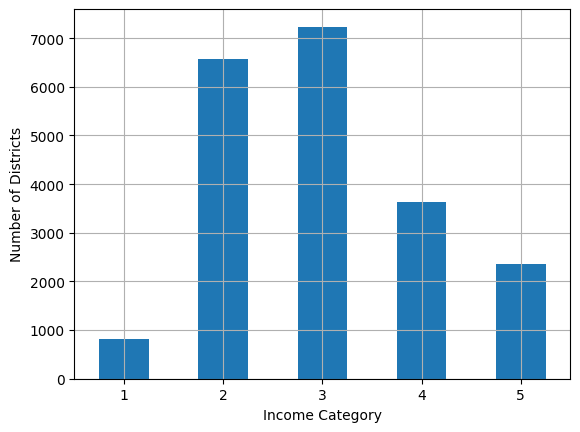

In [9]:
housing["income_cat"] = pd.cut(housing["median_income"], bins = [0., 1.5, 3.0, 4.5, 6.0, np.inf], labels = [1,2,3,4,5])
#bins represent the categories: 0 - $15,000, $15,000 - $30,000 and so on. The last categories contains $60,000 and has no upper limit.

#plotting
housing["income_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("Income Category")
plt.ylabel("Number of Districts")
plt.show()

### Analysing Median Income Histogram:
Most values are clustered around 1.5 to 6 (15000$ - 60000$), some go far beyond 6.
-- It is important to have enough instances of each stratum in your dataset, or else the estimate of stratum's importance may be biased.

THIS MEANS - The dataset should not have too many stratum and each stratum should be large enough.
The following code cell categorized the median incomes by introducing a new column.

In [10]:
#bins are the categories, np.inf indicates that there is no upper limit (6 to infinity)
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

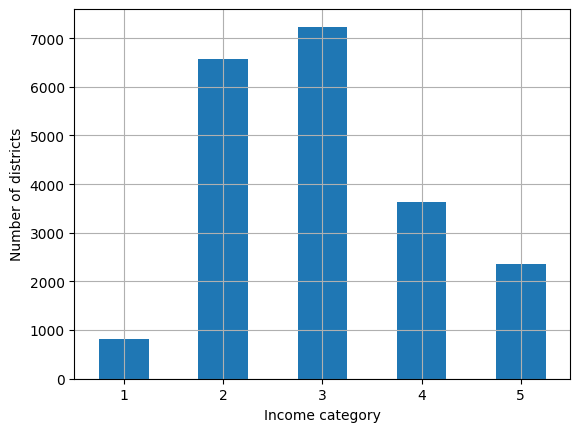

In [11]:
housing["income_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("Income category")
plt.ylabel("Number of districts")
plt.show()

Doing Stratified Sampling based on the income category: <br>
Sklearn has various splitter classes that implement various strategies to split the data into TEST and TRAIN set
Some Splitter and their properties are: <br>
1. train_test_split() → random split <br>
2. StratifiedShuffleSplit → one-time stratified split (splits while preserving the proportions)<br>
3. StratifiedKFold → multiple stratified splits (useful for cross-validation) <br>

Each splitter has a split() method that returns an iterator over different training/test splits of the same data i.e. it gived the training and test indices.
Doing multiple splits in a machine learning model can be used to better estimate the performance of your model.


In [12]:
# the attribute n_splits creates 10 splits of the data (these can be used for cross-validation.)
splitter = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)

#strat_splits is the list that will store all the 10 splits
strat_splits = []

#Inside the .split(), housing is the full dataset including the label, while the second argument is the column against which stratified sampling has to be done.
#It returns two arrays, train_index and test_index (both have the same proportions as the original dataset)
for train_index, test_index in splitter.split(housing, housing["income_cat"]):

    #getting actual dataframes from the indices using .iloc which selects rows by index position.
    strat_train_set_n = housing.iloc[train_index]
    strat_test_set_n = housing.iloc[test_index]

    #The training set and the test set is added to the list. (It is a 2D list, where internal lists contain both train and test sets.)
    strat_splits.append([strat_train_set_n, strat_test_set_n])

#To use one of the split pairs from the strat_splits:
# strat_train_set, strat_test_set = strat_splits[0] 

There is a simpler way to do stratified sampling:

In [13]:
strat_train_set, strat_test_set = train_test_split(housing, test_size=0.2, stratify=housing["income_cat"], random_state=42)

It is always better to check if the stratified sampling was successful or not:

In [14]:
(strat_test_set["income_cat"].value_counts()/len(strat_test_set))*100

income_cat
3    35.053295
2    31.879845
4    17.635659
5    11.434109
1     3.997093
Name: count, dtype: float64

In [15]:
(housing["income_cat"].value_counts()/len(housing))*100

income_cat
3    35.058140
2    31.884690
4    17.630814
5    11.443798
1     3.982558
Name: count, dtype: float64

Now, after the stratified sampling, there is no need for the income_cat column so it is better to drop it:

In [16]:
# set_ is just a variable that is first equal to strat_train set and then strat_test_set
for set_ in (strat_train_set, strat_test_set):
    #drops the column (axis = 1 tells pandas that a column has to be dropped not a row (axis = 0))
    set_.drop("income_cat", axis=1, inplace=True)

# Exploring the data to gain insights

Creating a copy of the train set so that at a later time, if we have to, we can use the original train set. The copy can be used for data exploration and any changes you want to make

In [17]:
housing = strat_test_set.copy()

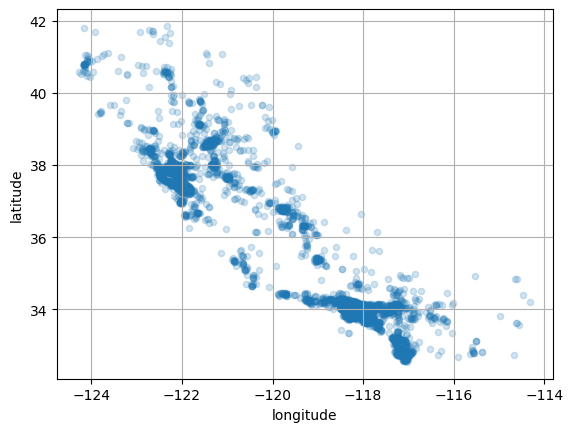

In [18]:
#visualizing the geographical columns.
housing.plot(kind = "scatter", x = "longitude", y="latitude", grid=True, alpha = 0.2)
plt.show()

In the above plot, high density areas can be observed. To observe the population and median incomes of people, the following attributes are used: <br>
1. Attribute s - This varies the size of the dots depending on the population of that area.
2. Attribute c -  maps the color to median house value
3. cmap="jet" - colormap (jet = rainbow style)
4. sharex=False -  don’t share x-axis with other plots

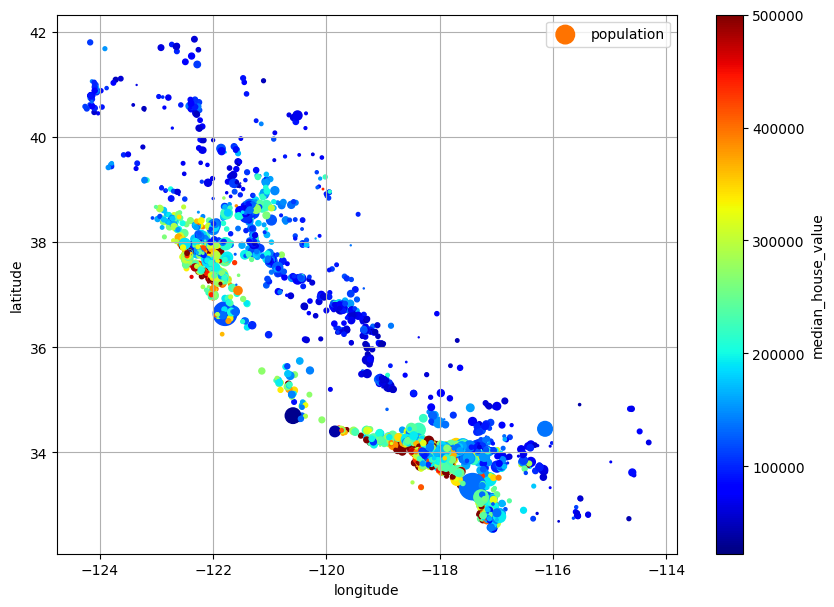

In [19]:
housing.plot(kind="scatter", x = "longitude", y="latitude", grid=True, s = housing["population"]/100, label = "population", c = "median_house_value", cmap="jet", colorbar=True,
             legend=True, sharex=False, figsize=(10, 7))
plt.show()

Observations: <br>
It can be seen in the above plot that the housing princes are greatly related to the population density. (red points represent expensive houses while blue ones represent cheaper ones.)

## Looking for Correlaions

Correlation between attributes and labels can tell how they are related. The correlation coefficient ranges from -1 to 1. <br>
1. If coefficient is close to -1 - There is a strong negative correlation (you can think of it as strong negative correlation.)
2. If coefficient is close to 1 - There is a strong positive correlation.
3. If coefficient is close to 0 - There is no linear correlation.

In [20]:
corr_matrix = housing.select_dtypes(include=[np.number]).corr() #this only takes in the numeric columns, otherwise it will return an error
corr_matrix["median_house_value"]

longitude            -0.026768
latitude             -0.162087
housing_median_age    0.118976
total_rooms           0.121070
total_bedrooms        0.029600
population           -0.040286
households            0.043549
median_income         0.687091
median_house_value    1.000000
Name: median_house_value, dtype: float64

In [21]:
#The correlation can be visually checked using the following scatter plots.
attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))
plt.show()

NameError: name 'scatter_matrix' is not defined

In the above figures, it can be seen that median_house_value is strongly correlated to the median_income. <br>
See, it also has the highest correlation score (0.6).
Lets Zoom in on the scatterplot:

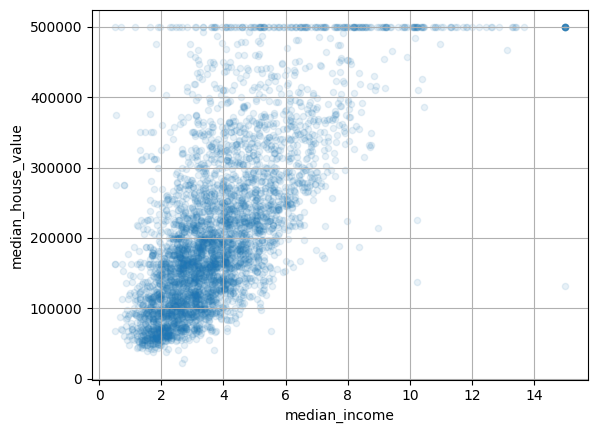

In [ ]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1, grid=True)
plt.show()

From the plot, the following things can be observed:
1. The cap on the median_house_value is visible at $500,000.
2. There is an upward trend and the points are not too dispersed.

## Experimenting with Attribute Combinations
Experimenting witht variosu attribute combinations can be useful while preparing the data for the algorithm.
For example, the number of rooms in a district is not vary useful if the number of households is not known. What is useful is the number of rooms per households. <br>
Similarly, the attributes can be combined to test how well related they are to the target value. <br>
Some interesting combinations are:
1. rooms_per_house
2. bedroom_ratio
3. people_per_house

In [ ]:
#These lines of code add the new combined attributes with the computed values.
housing["rooms_per_house"] = housing["total_rooms"]/housing["households"]
housing["bedroom_ratio"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["people_per_house"] = housing["population"]/housing["households"]


In [ ]:
corr_matrix = housing.select_dtypes(include=[np.number]).corr() #this only takes in the numeric columns, otherwise it will return an error
corr_matrix["median_house_value"]

longitude            -0.026768
latitude             -0.162087
housing_median_age    0.118976
total_rooms           0.121070
total_bedrooms        0.029600
population           -0.040286
households            0.043549
median_income         0.687091
median_house_value    1.000000
rooms_per_house       0.198322
bedroom_ratio        -0.254506
people_per_house     -0.025974
Name: median_house_value, dtype: float64

Observation:
The new bedrooms_ratio attribute (-0.25) is much more correlated with the median house value than the total number of rooms or bedrooms (0.12/0.029). (STRONG NEGATIVE CORRELATION) <br>

NOTE: The purpose of this phase is to get a few insights. Training a model is not a linear process. After the first prototype, accuracy can be tested and you can come back to this step to experminet with other columns and choose what works the best.


# Preparing the data for the Algorithm

In the code below, a copy of the data is made and the label column is dropped from the dataset. <br>
Note: .drop() does not affect the original dataframe, it just returns a copy of the dataset after removing the specified column.

In [ ]:
#axis = 1 means column.
housing  = strat_train_set.drop("median_house_value", axis = 1)
housing_labels = strat_train_set["median_house_value"].copy()



### Data Cleaning

In [ ]:
#Getting information about the  columns in the dataset.
housing.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16512 entries, 13096 to 19888
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16344 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
 8   ocean_proximity     16512 non-null  object 
dtypes: float64(8), object(1)
memory usage: 1.8+ MB


It can be seen that "total_bedrooms" column has null values. There are 3 ways to handle this situation:<br>
1. Get rid of that data. <br>
2. Get rid of the whole attribute (can be considered if the attribute is not correlated to to the target variable) <br>
3. Perform IMPUTATION - Change the missing to zero, mean or the median. <br>

Here we will use the third option because it is lest destructive to our data. <br>
SciKit Learn has a SimpleImputer class that stores median values and other values for the numerical columns.


In [23]:
imputer = SimpleImputer(strategy = "median")
#Because you can only compute the median of numerical columns, a copy of the dataset has to be created
#which only has numerical attributes

"""

Other strategies include: 
1. strategy="mean"
2. strategy="most_frequent"               -- supports non-numerical attributes
3. (strategy="constant", fill_value=…​).   -- supports non-numerical attributes

"""
housing_num = housing.select_dtypes(include=[np.number])

imputer.fit(housing_num)

#This will store the medians in the statistics_ instance variable

,missing_values,nan
,strategy,'median'
,fill_value,None
,copy,True
,add_indicator,False
,keep_empty_features,False


Some other powerful imputers available in SKLearn:
1. KNNImputer
2. IterativeImputer

In [29]:
X = imputer.transform(housing_num)
